In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np

# Fetch dataset 
adult = fetch_ucirepo(id=2) 

# Data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# 1. First filter missing values from features
columns_to_check = ['workclass', 'native-country', 'occupation']
mask = (~X[columns_to_check].isin(['?']) & ~X[columns_to_check].isna()).all(axis=1)
filtered_X = X[mask].copy()
filtered_y = y[mask].copy()

# 2. Then clean the income column in the filtered data
filtered_y['income'] = filtered_y['income'].str.rstrip('.')

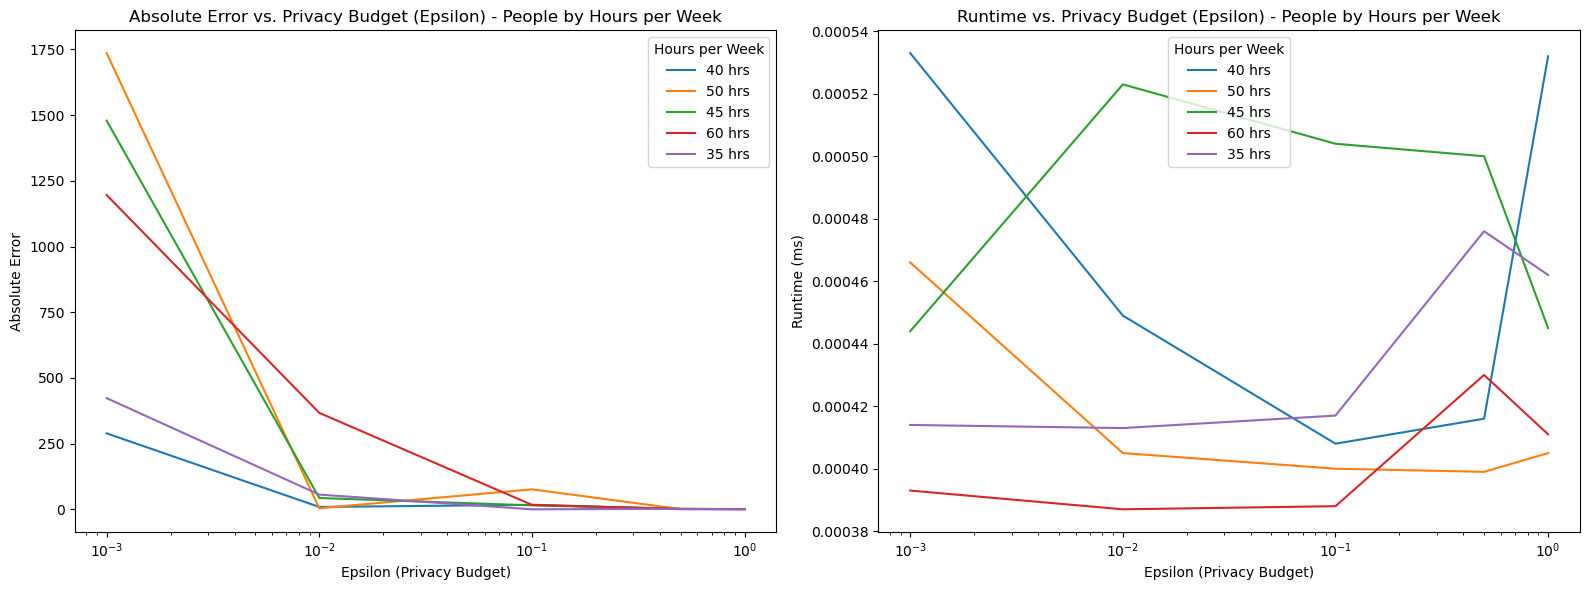

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Define privacy budgets
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Find top 5 most common hours-per-week values
top_hours = combined_df['hours-per-week'].value_counts().nlargest(5).index.tolist()

# Calculate results
results = []
np.random.seed(42)

for hours in top_hours:
    # Count people working this many hours
    true_count = len(combined_df[combined_df['hours-per-week'] == hours])
    
    for epsilon in epsilon_values:
        dp_count = laplace_mechanism(true_count, epsilon)
        runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
        abs_error = abs(true_count - dp_count)
        
        results.append({
            'Hours per Week': f'{hours} hrs',
            'Epsilon': epsilon,
            'True Count': true_count,
            'Absolute Error': abs_error,
            'Runtime (ms)': round(runtime, 6)
        })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Hours per Week', 
             markers=True, dashes=False, data=results_df, ax=ax1)
ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon) - People by Hours per Week')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Hours per Week', 
             markers=True, dashes=False, data=results_df, ax=ax2)
ax2.set_title('Runtime vs. Privacy Budget (Epsilon) - People by Hours per Week')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

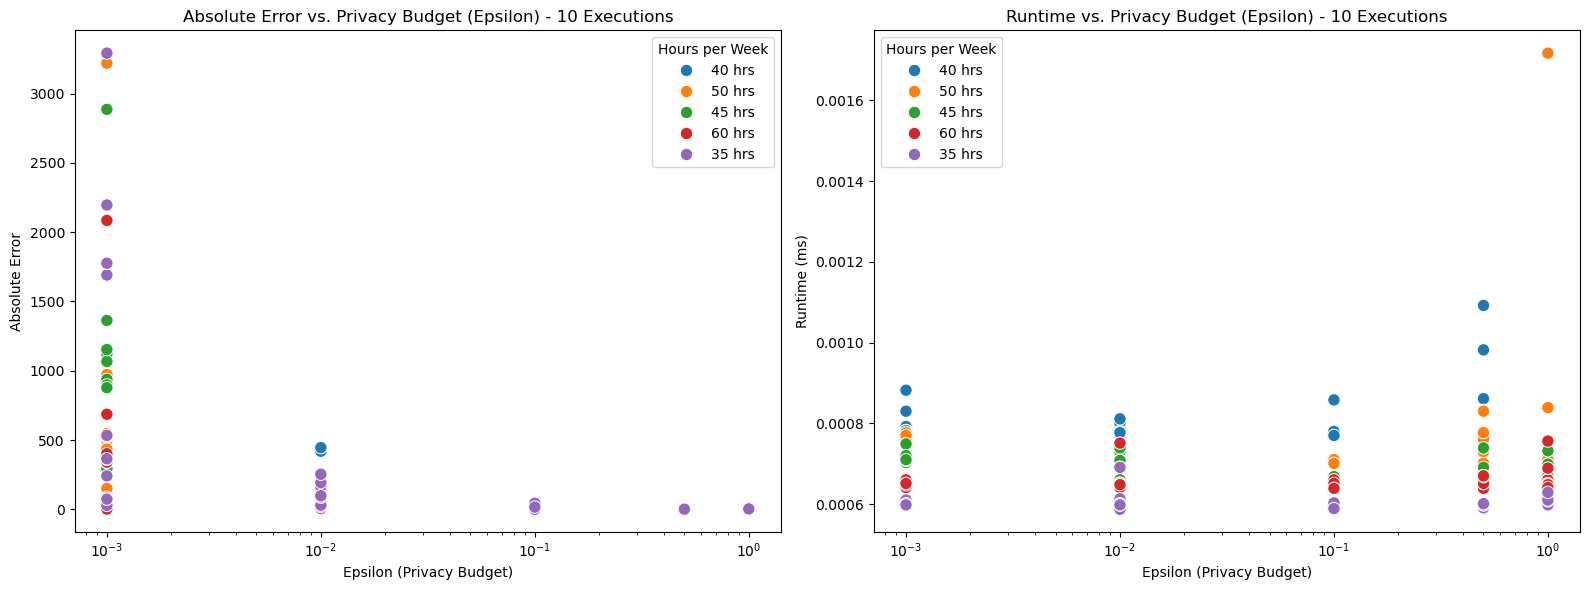

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Define privacy budgets
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]
num_executions = 10

# Find top 5 most common hours-per-week values
top_hours = combined_df['hours-per-week'].value_counts().nlargest(5).index.tolist()

# Calculate results for multiple executions
results = []
np.random.seed(42)

for hours in top_hours:
    # Count people working this many hours
    true_count = len(combined_df[combined_df['hours-per-week'] == hours])
    
    for epsilon in epsilon_values:
        # Run 10 independent executions
        for execution in range(num_executions):
            dp_count = laplace_mechanism(true_count, epsilon)
            runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
            abs_error = abs(true_count - dp_count)
            
            results.append({
                'Hours per Week': f'{hours} hrs',
                'Epsilon': epsilon,
                'True Count': true_count,
                'DP Count': dp_count,
                'Absolute Error': abs_error,
                'Runtime (ms)': round(runtime, 6),
                'Execution': execution + 1
            })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Hours per Week', 
                data=results_df, s=80, ax=ax1)  # s controls the dot size
ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Hours per Week', 
                data=results_df, s=80, ax=ax2)  # s controls the dot size
ax2.set_title('Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()